# MNIST Classifier
Training a basic feedforward neural network to classify handwritten
digits from the MNIST database

In [55]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
import os
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tqdm import tqdm
plt.style.use('ggplot')

In [ ]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./datasets/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./datasets/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
# Show a few of the images
fig, ax = plt.subplots(1,3)
for i in range(3):
    ax[i].imshow(example_data[i].squeeze(), cmap='gray')
    ax[i].set(title=f"{example_targets[i]}")
    ax[i].set_xticks([])
    ax[i].set_yticks([])


In [ ]:
# Create the neural network
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
input_size = 784 # 28x28 pixel images
hidden_size = 196 # 196
num_classes = 10 # 10 classes
model = NeuralNet(input_size, hidden_size, num_classes)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
loss_hist = []
count = 0
for batch_idx, (data, target) in enumerate(train_loader):
    model.train()
    optimizer.zero_grad()

    # Do a forward pass to get a prediction from the model
    pred = model(data)

    # Compute the loss
    loss = criterion(pred, target)

    if count > 10:
        loss_val = loss.detach().item()
        print(loss_val)
        loss_hist.append(loss_val)
        count = 0
    else:
        count += 1

    # Compute gradients and take a gradient step
    loss.backward()
    optimizer.step()



In [ ]:
plt.plot(loss_hist)

In [51]:
three = example_data[0]
nine = example_data[4]

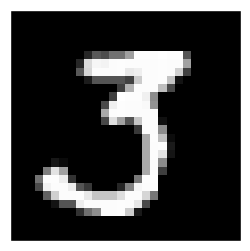

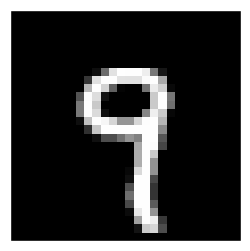

In [53]:
plt.figure(figsize=(3,3))
plt.xticks([]); plt.yticks([])
plt.imshow(three.squeeze(), cmap="gray")

plt.figure(figsize=(3,3))
plt.xticks([]); plt.yticks([])
plt.imshow(nine.squeeze(), cmap="gray")


In [72]:
res = model(nine).detach()
res = F.softmax(res, dim=1).numpy().flatten()
res = np.round(res, 3)
for i in range(len(res)):
    print(f"{i}: {100*res[i]} %")

0: 0.0 %
1: 0.0 %
2: 0.0 %
3: 0.4999999888241291 %
4: 2.4000000208616257 %
5: 0.4000000189989805 %
6: 0.0 %
7: 2.800000086426735 %
8: 0.4000000189989805 %
9: 93.50000023841858 %
